# Inference

- [Baseline model](#Baseline-model)
- [Predictive checking](#Predictive-checking)
- [Inferential Vs Predictive uncertainty](#Inferential-Vs-Predictive-uncertainty)
    - [Point predictive simulation](#Point-predictive-simulation)
    - [New data](#New-data)
- [Model performance](#Model-performance)

In [1]:
%matplotlib inline
from IPython.display import Image

import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.preprocessing import scale
from sklearn import metrics

In [2]:
db = pandas.read_csv('../data/paris_abb.csv.zip')
db['l_price'] = np.log1p(db['Price'])
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50280 entries, 0 to 50279
Data columns (total 11 columns):
id                        50280 non-null int64
neighbourhood_cleansed    50280 non-null object
property_type             50280 non-null object
room_type                 50280 non-null object
accommodates              50280 non-null int64
bathrooms                 50280 non-null float64
bedrooms                  50280 non-null float64
beds                      50280 non-null float64
bed_type                  50280 non-null object
Price                     50280 non-null float64
l_price                   50280 non-null float64
dtypes: float64(5), int64(2), object(4)
memory usage: 4.2+ MB


## Baseline model

$$
\log(P) = \alpha + X \beta + \epsilon
$$

$X$:

- Bathrooms
- Bedrooms
- Beds
- Room type

In [3]:
m1 = sm.ols('l_price ~ bedrooms + bathrooms + beds', db).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     5433.
Date:                Wed, 15 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:41:37   Log-Likelihood:                -38592.
No. Observations:               50280   AIC:                         7.719e+04
Df Residuals:                   50276   BIC:                         7.723e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1806      0.005    852.126      0.000       4.171       4.190
bedrooms       0.2253      0.004     57.760      0.000       0.218       0.233
bathrooms     -0.1544      0.005    -32.373      0.000      -0.164      -0.145
beds           0.1398      0.003     50.554      0.000       0.134       0.145
==============================================================================
Omnibus:                    11384.882   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           585415.122
Skew:                          -0.096   Prob(JB):                         0.00
Kurtosis:                      19.715   Cond. No.                         7.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To note:

- Decent $R^2$ (although that's not holy truth)
- Every variable significant and related as expected
- Interpret coefficients

In [4]:
cols = ['bedrooms', 'bathrooms', 'beds']
scX = pandas.DataFrame(scale(db[cols]),
                       index=db.index,
                       columns=cols)
scX.describe()

,bedrooms,bathrooms,beds
count,5.028000e+04,5.028000e+04,5.028000e+04
mean,4.522149e-17,-7.871366e-17,5.087418e-18
std,1.000010e+00,1.000010e+00,1.000010e+00
min,-1.076738e+00,-1.625116e+00,-1.429042e+00
25%,-7.772733e-02,-1.702805e-01,-5.706025e-01
50%,-7.772733e-02,-1.702805e-01,-5.706025e-01
75%,-7.772733e-02,-1.702805e-01,2.878366e-01
max,4.887380e+01,7.111664e+01,4.149292e+01


In [5]:
m2 = sm.ols('l_price ~ bedrooms + bathrooms + beds', 
            data=scX.join(db['l_price']))\
       .fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     5433.
Date:                Wed, 15 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:41:37   Log-Likelihood:                -38592.
No. Observations:               50280   AIC:                         7.719e+04
Df Residuals:                   50276   BIC:                         7.723e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4837      0.002   1928.462      0.000       4.479       4.488
bedrooms       0.2255      0.004     57.760      0.000       0.218       0.233
bathrooms     -0.1061      0.003    -32.373      0.000      -0.113      -0.100
beds           0.1628      0.003     50.554      0.000       0.156       0.169
==============================================================================
Omnibus:                    11384.882   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           585415.122
Skew:                          -0.096   Prob(JB):                         0.00
Kurtosis:                      19.715   Cond. No.                         3.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's bring both sets of results together:

In [6]:
pandas.DataFrame({"Baseline": m1.params,
                  "X Std.": m2.params
                 })

,Baseline,X Std.
Intercept,4.180599,4.483657
bedrooms,0.225325,0.225548
bathrooms,-0.154385,-0.106119
beds,0.139759,0.162806


To note:

How does interpretation of the coefficients change?
* Meaning of intecept when $X$ is demeanded
* Units in which $\beta$ are interpreted

## Predictive checking

Is the model picking up the overall "shape of data"?

- Important to know how much we should trust our inferences
- Crucial if we want to use the model to predict!

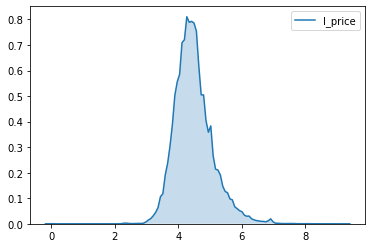

In [7]:
sns.kdeplot(db['l_price'], shade=True)

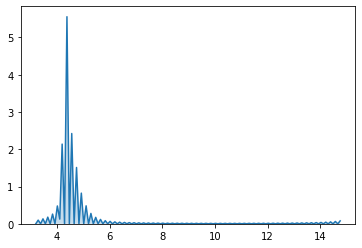

In [8]:
sns.kdeplot(m1.fittedvalues, shade=True)

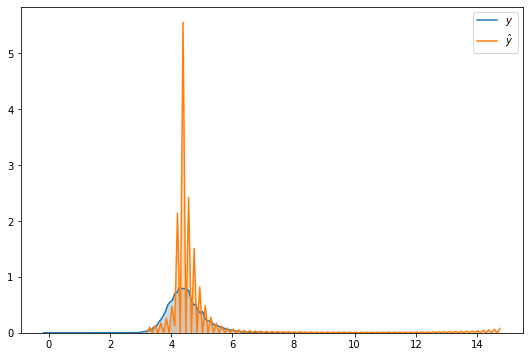

In [9]:
f, ax = plt.subplots(1, figsize=(9, 6))
sns.kdeplot(db['l_price'], shade=True, ax=ax, label='$y$')
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}$')
plt.show()

To note:

- Not a terrible start
- How could we improve it?

In [10]:
m3 = sm.ols('l_price ~ bedrooms + bathrooms + beds + room_type', db).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     4314.
Date:                Wed, 15 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:41:38   Log-Likelihood:                -35210.
No. Observations:               50280   AIC:                         7.043e+04
Df Residuals:                   50273   BIC:                         7.050e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.2417      0.005    899.941      0.000       4.232       4.251
room_type[T.Hotel room]       0.5548      0.016     35.619      0.000       0.524       0.585
room_type[T.Private room]    -0.4862      0.007    -66.604      0.000      -0.501      -0.472
room_type[T.Shared room]     -1.0320      0.028    -36.320      0.000      -1.088      -0.976
bedrooms                      0.2388      0.004     65.134      0.000       0.232       0.246
bathrooms                    -0.1440      0.004    -32.285      0.000      -0.153      -0.135
beds                          0.1144      0.003     43.386      0.000       0.109       0.120
==============================================================================
Omnibus:                    11695.728   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           680804.847
Skew:                          -0.027   Prob(JB):                         0.00
Kurtosis:                      21.027   Cond. No.                         37.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

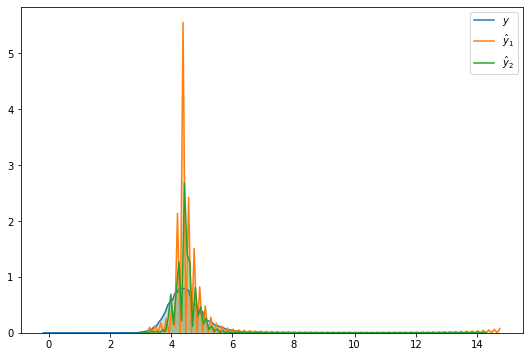

In [11]:
f, ax = plt.subplots(1, figsize=(9, 6))
sns.kdeplot(db['l_price'], shade=True, ax=ax, label='$y$')
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}_1$')
sns.kdeplot(m3.fittedvalues, shade=True, ax=ax, label='$\hat{y}_2$')
plt.show()

To note:

- This is better!
- But these are only point predictions. Sometimes that's good enough.
- Usually however, we want a model to capture the underlying process instead of the particular realisation observed (ie. dataset).
- Then we need to think about the uncertainty embedded in the model we are estimating

## Inferential Vs Predictive uncertainty

[See more in Chapter 7.2 of [Gelman & Hill 2006](http://www.stat.columbia.edu/~gelman/arm/) 👌💯]

- Two types of uncertainty in our model
    + Predictive ($\epsilon$)
    + Inferential ($\beta$)
- Both affect the final predictions we make

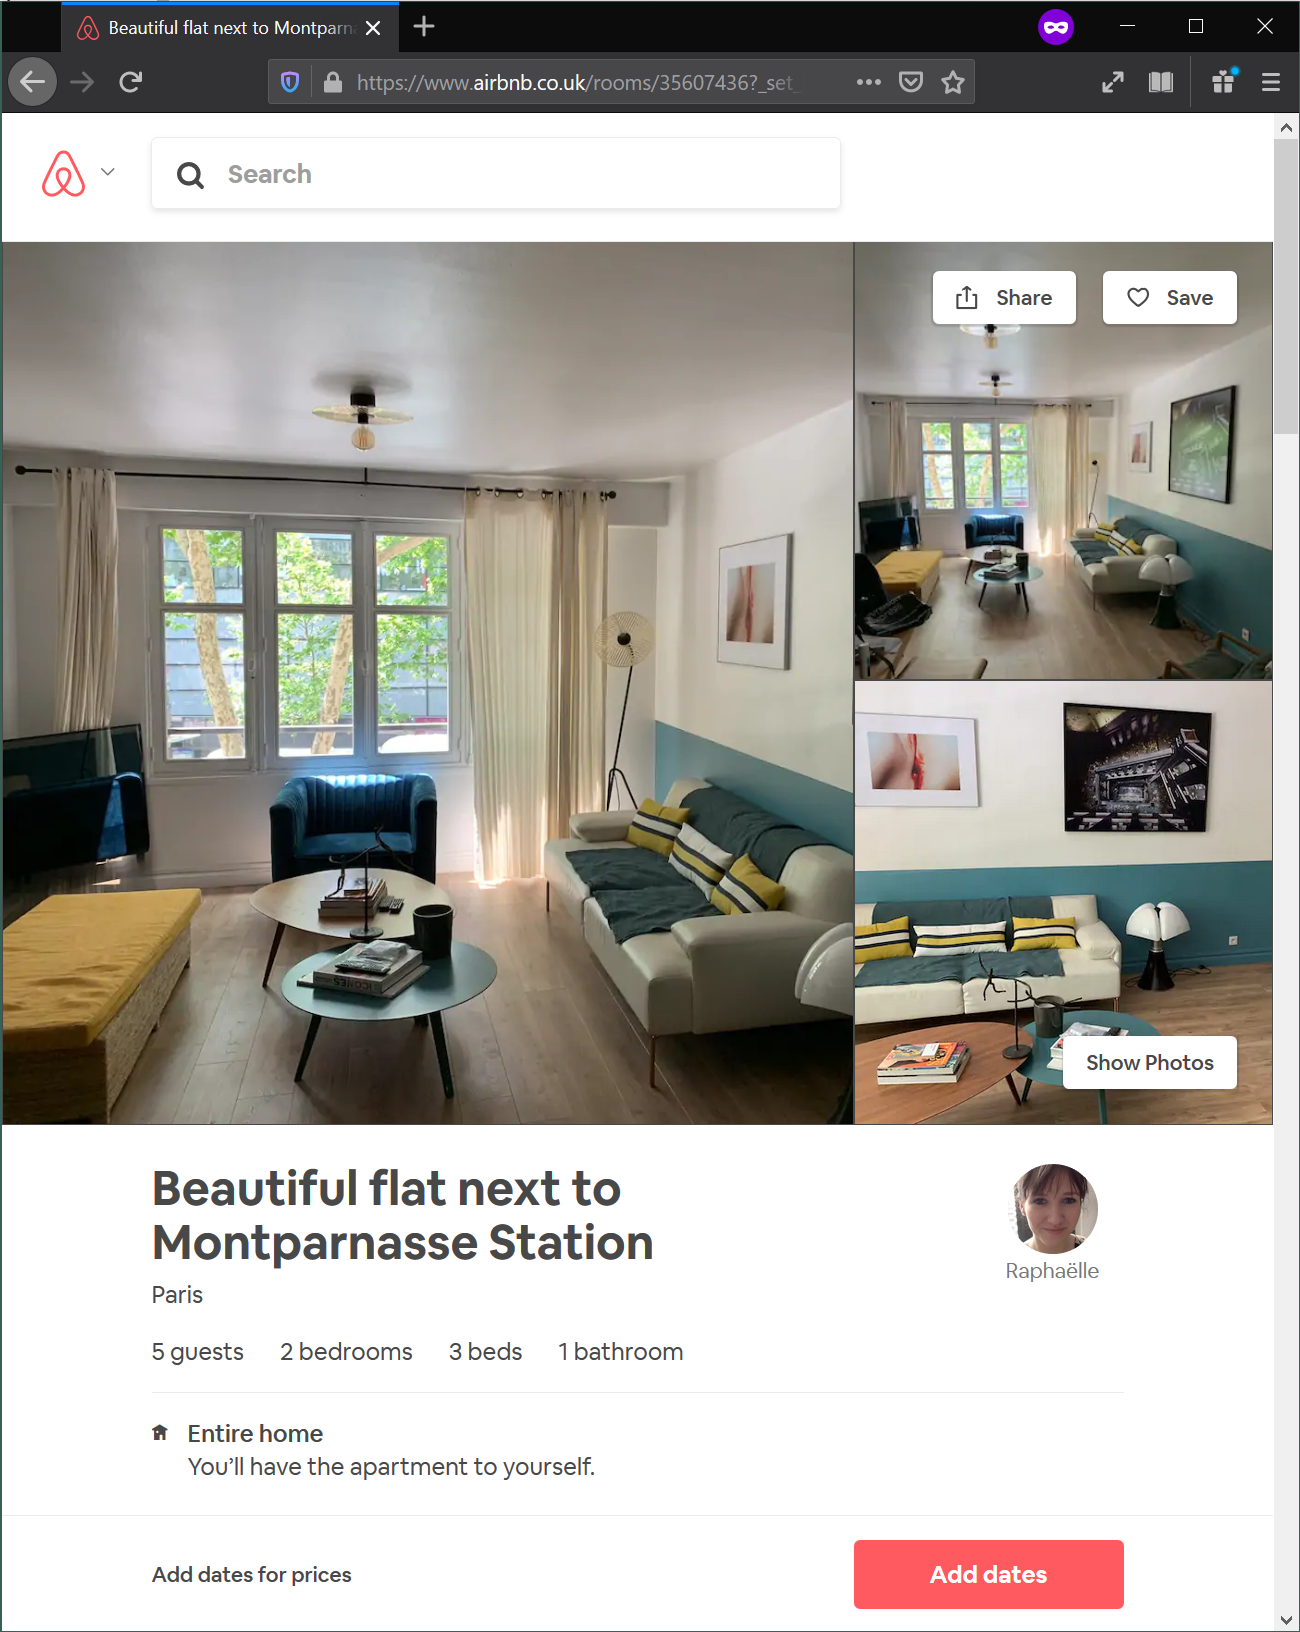

In [12]:
Image("../figs/abb_room.png", retina=True)

In [13]:
room = db.loc[db['id']==35607436, :]
room.T

,45979
id,35607436
neighbourhood_cleansed,Luxembourg
property_type,Apartment
room_type,Entire home/apt
accommodates,5
bathrooms,1
bedrooms,2
beds,3
bed_type,Real Bed
Price,90


In [14]:
rid = room.index[0]
db.loc[rid, :]

id                               35607436
neighbourhood_cleansed         Luxembourg
property_type                   Apartment
room_type                 Entire home/apt
accommodates                            5
bathrooms                               1
bedrooms                                2
beds                                    3
bed_type                         Real Bed
Price                                  90
l_price                           4.51086
Name: 45979, dtype: object

$$
\hat{\log(P_i)} = \alpha + \sum_k \beta_k * X_k
$$

In [15]:
m1.params['Intercept'] + db.loc[rid, cols].dot(m1.params[cols])

4.896141184855212

To note:

- What does `dot` do?

In [16]:
m1.fittedvalues[rid]

4.896141184855212

### Point predictive simulation

In [17]:
%%time
# Parameters
## Number of simulations
r = 2000
# Pull out characteristics for house of interest
x_i = db.loc[rid, cols]
# Specify model engine
model = m1

# Place-holder
sims = np.zeros(r)
# Loop over number of replications
for i in range(r):
    # Get a random draw of betas
    rbs = np.random.normal(model.params, model.bse)
    # Get a random draw of epsilon
    re = np.random.normal(0, model.scale)
    # Obtain point estimate
    y_hr = rbs[0] + np.dot(x_i, rbs[1:]) + re
    # Store estimate
    sims[i] = y_hr

CPU times: user 1.14 s, sys: 10 ms, total: 1.15 s
Wall time: 1.15 s


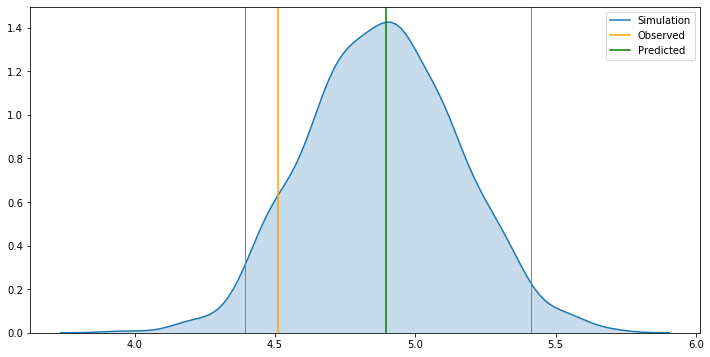

In [18]:
f, ax = plt.subplots(1, figsize=(12, 6))

sns.kdeplot(sims, shade=True, ax=ax, label='Simulation')
ax.axvline(db.loc[rid, 'l_price'], c='orange', label='Observed')
ax.axvline(model.fittedvalues[rid], c='green', label='Predicted')

lo, up = pandas.Series(sims)\
               .sort_values()\
               .iloc[[int(np.round(0.025 * r)), int(np.round(0.975 * r))]]
ax.axvline(lo, c='grey', linewidth=1)
ax.axvline(up, c='grey', linewidth=1)

plt.legend()
plt.show()

To note:

- Intuition of the simulation
- The `for` loop, deconstructed
- The graph, bit by bit
- If we did this for every observation, we'd expect 95% to be within the 95% bands

---

**Exercise**

Explore with the code above and try to generate similar plots for:

- Different houses across locations and characteristics
- Different model

**Exercise+**

Recreate the analysis above for observation `5389821`. What happens? Why?

---

Now, we could do this for ***all*** the observations and get a sense of the overall distribution to be expected

In [19]:
%%time
# Parameters
## Number of observations & simulations
n = db.shape[0]
r = 200
# Specify model engine
model = m1

# Place-holder (N, r)
sims = np.zeros((n, r))
# Loop over number of replications
for i in range(r):
    # Get a random draw of betas
    rbs = np.random.normal(model.params, model.bse)
    # Get a random draw of epsilon
    re = np.random.normal([0]*n, model.scale)
    # Obtain point estimate
    y_hr = rbs[0] + np.dot(db[cols], rbs[1:]) + re
    # Store estimate
    sims[:, i] = y_hr

CPU times: user 4.7 s, sys: 1.54 s, total: 6.24 s
Wall time: 3.14 s


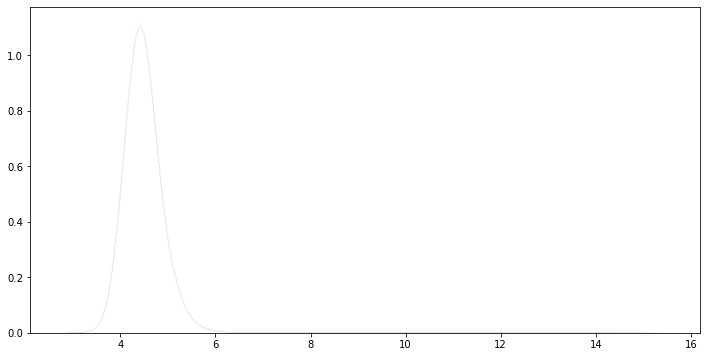

In [20]:
f, ax = plt.subplots(1, figsize=(12, 6))

for i in range(10):
    sns.kdeplot(sims[:, i], ax=ax, linewidth=0.1, alpha=0.1, color='k')
    
plt.show()

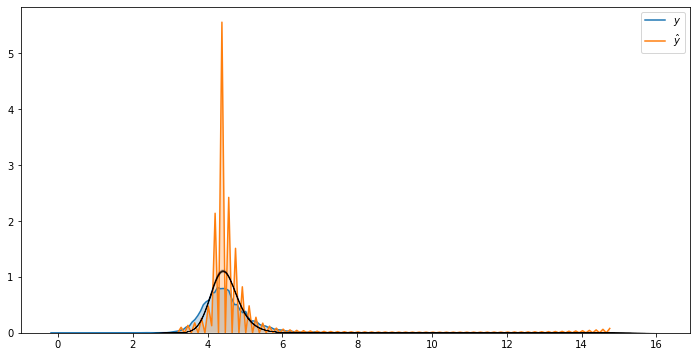

In [21]:
f, ax = plt.subplots(1, figsize=(12, 6))

sns.kdeplot(db['l_price'], shade=True, ax=ax, label='$y$')
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}$')

for i in range(r):
    sns.kdeplot(sims[:, i], ax=ax, linewidth=0.1, alpha=0.1, color='k')
    
plt.show()

To note:

- Black line contains `r` thin lines that collectively capture the uncertainty behind the model

### New data

Imagine we are trying to figure out how much should we charge for a property we want to put on AirBnb.

For example, let's assume our property is:

In [22]:
new = pandas.Series({'bedrooms': 4,
                     'bathrooms': 1,
                     'beds': 8})

In [23]:
%%time
# Parameters
## Number of simulations
r = 2000
# Pull out characteristics for house of interest
x_i = new
# Specify model engine
model = m1

# Place-holder
sims = np.zeros(r)
# Loop over number of replications
for i in range(r):
    # Get a random draw of betas
    rbs = np.random.normal(model.params, model.bse)
    # Get a random draw of epsilon
    re = np.random.normal(0, model.scale)
    # Obtain point estimate
    y_hr = rbs[0] + np.dot(x_i, rbs[1:]) + re
    # Store estimate
    sims[i] = y_hr

CPU times: user 1.1 s, sys: 50 ms, total: 1.15 s
Wall time: 1.15 s


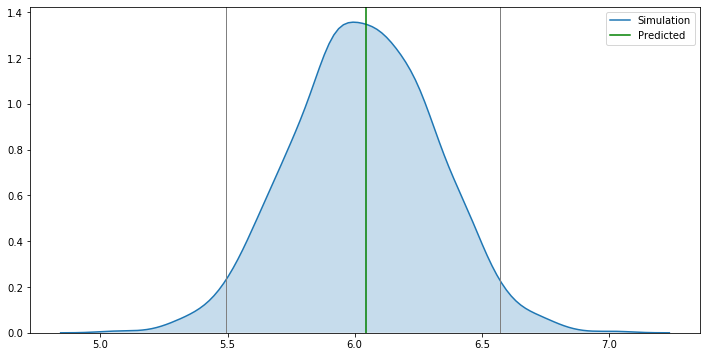

In [24]:
f, ax = plt.subplots(1, figsize=(12, 6))

sns.kdeplot(sims, shade=True, ax=ax, label='Simulation')
ax.axvline(model.params.iloc[0] + np.dot(new, model.params.iloc[1:]), \
           c='green', label='Predicted')

lo, up = pandas.Series(sims)\
               .sort_values()\
               .iloc[[int(np.round(0.025 * r)), int(np.round(0.975 * r))]]
ax.axvline(lo, c='grey', linewidth=1)
ax.axvline(up, c='grey', linewidth=1)

plt.legend()
plt.show()

**[Pro]**

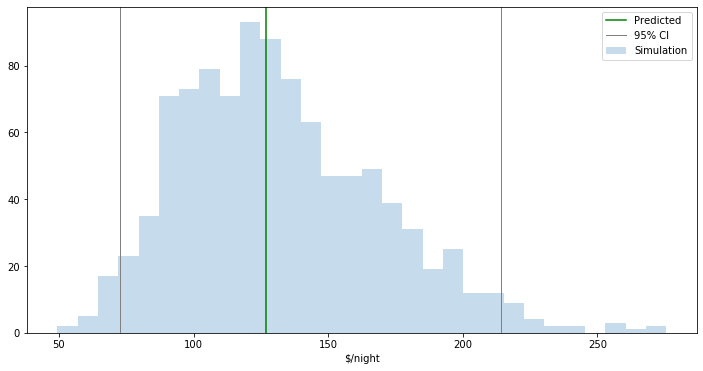

In [25]:
def predictor(bedrooms, bathrooms, beds):
    new = pandas.Series({'bedrooms': bedrooms,
                         'bathrooms': bathrooms,
                         'beds': beds
                        })
    r = 1000
    x_i = new
    model = m1
    y_hat = model.params.iloc[0] + np.dot(new, model.params.iloc[1:])
    # Simulation
    sims = np.zeros(r)
    for i in range(r):
        rbs = np.random.normal(model.params, model.bse)
        re = np.random.normal(0, model.scale)
        y_hr = rbs[0] + np.dot(x_i, rbs[1:]) + re
        sims[i] = y_hr
    sims = np.exp(sims)
    y_hat = np.exp(y_hat)    
    # Bands
    lo, up = pandas.Series(sims)\
                   .sort_values()\
                   .iloc[[int(np.round(0.025 * r)), int(np.round(0.975 * r))]]
    # Setup'n'draw figure
    f, ax = plt.subplots(1, figsize=(12, 6))
    ax.hist(sims, label='Simulation', alpha=0.25, bins=30)
    ax.axvline(y_hat, c='green', label='Predicted')
    ax.axvline(lo, c='grey', linewidth=1, label='95% CI')
    ax.axvline(up, c='grey', linewidth=1)
    #ax.set_xlim((0, 10))
    # Dress up
    ax.set_xlabel("$/night")
    plt.legend()
    return plt.show()

predictor(3, 1, 1)

In [26]:
# You might have to run this to make interactives work
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
# From https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-the-jupyterlab-extension
# Then restart Jupyter Lab
from ipywidgets import interact, IntSlider

interact(predictor, 
         bedrooms=IntSlider(min=1, max=10), \
         bathrooms=IntSlider(min=0, max=10), \
         beds=IntSlider(min=1, max=20)
        );

interactive(children=(IntSlider(value=1, description='bedrooms', max=10, min=1), IntSlider(value=0, descriptio…

## Model performance

To note:

- Switch from inference to prediction
- Overall idea of summarising model performance
- $R^2$
- Error-based measures

In [27]:
# R^2
r2 = pandas.Series({'Baseline': metrics.r2_score(db['l_price'],
                                                 m1.fittedvalues),
                    'Augmented': metrics.r2_score(db['l_price'],
                                                  m3.fittedvalues)})
r2

Baseline     0.244826
Augmented    0.339876
dtype: float64

In [28]:
# MSE
mse = pandas.Series({'Baseline': metrics.mean_squared_error(db['l_price'],
                                                            m1.fittedvalues),
                     'Augmented': metrics.mean_squared_error(db['l_price'],
                                                             m3.fittedvalues)})
mse

Baseline     0.271771
Augmented    0.237565
dtype: float64

In [29]:
# MAE
mae = pandas.Series({'Baseline': metrics.mean_absolute_error(db['l_price'],
                                                             m1.fittedvalues),
                     'Augmented': metrics.mean_absolute_error(db['l_price'],
                                                              m3.fittedvalues)})
mae

Baseline     0.379119
Augmented    0.357287
dtype: float64

In [30]:
# All
perf = pandas.DataFrame({'MAE': mae,
                         'MSE': mse,
                         'R^2': r2})
perf

,MAE,MSE,R^2
Baseline,0.379119,0.271771,0.244826
Augmented,0.357287,0.237565,0.339876
